In [43]:
import numpy as np
import copy
import scipy
from sklearn.metrics.pairwise import euclidean_distances
from scipy.optimize import minimize
import GPy
import matplotlib.pyplot as plt
from scipy import special
import math
from scipy.stats import norm

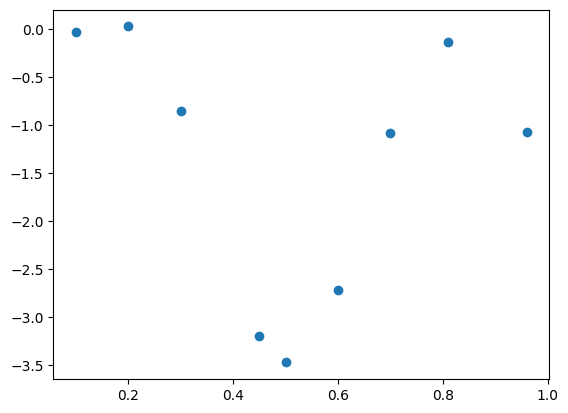

In [2]:
X_sample=np.array([[0]])
Y_sample=np.array([[0]])

np.random.seed(0)
kernel = GPy.kern.RBF(input_dim=1,variance=2.,lengthscale=0.2)
m = GPy.models.GPRegression(X_sample,Y_sample,kernel)
m.Gaussian_noise.variance.fix(10**(-5))

X = np.array([[0.1],[0.2],[0.3],[0.45],[0.5],[0.6],[0.7],[0.81],[0.96]])
Y = m.posterior_samples_f(X,size=1)
Y = Y.reshape(-1,1)

plt.scatter(X,Y)

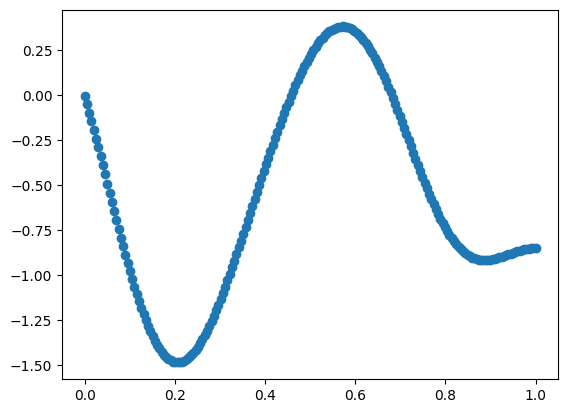

In [3]:
X_total = np.linspace(0,1,200).reshape(-1,1)
Y_total = m.posterior_samples_f(X_total,size=1)
Y_total = Y_total.reshape(-1,1)

plt.scatter(X_total,Y_total)

In [4]:
def cov_RBF(x1, x2, parameters):  
    
    lengthscale_square =   parameters[:,0]  # lengthscale^2
    variance = parameters[:,1] # sigma^2


    if x1.shape[1]!=x2.shape[1]:
        x1=np.reshape(x1,(-1,x2.shape[1]))

    Euc_dist=euclidean_distances(x1,x2)

    return variance*np.exp(-0.5*np.square(Euc_dist)/lengthscale_square)




def log_llk(X,y,parameters):

    noise_delta = 10**(-5)
    
    parameters = parameters.reshape(-1,2)

    KK_x_x=cov_RBF(X,X,parameters)+np.eye(len(X))*noise_delta     
    if np.isnan(KK_x_x).any(): #NaN
        print("nan in KK_x_x !")   

    try:
        L=scipy.linalg.cholesky(KK_x_x,lower=True)
        alpha=np.linalg.solve(KK_x_x,y)

    except: # singular
        return -np.inf
    
    try:
        first_term = -0.5*np.log(np.linalg.det(KK_x_x))
        
        KK_inv = np.linalg.inv(KK_x_x)
        second_term = -0.5* np.dot(np.dot(y.T,KK_inv),y)
            

    except: # singular
        return -np.inf

    logmarginal = first_term+second_term -0.5*len(y)*np.log(2*3.1415926)
    
    return logmarginal.item()


def optimise(X, y):

    opts ={'maxiter':1000,'maxfun':200,'disp': False}

    bounds = np.array([[0.025**2,1],[0.01,10]])
    hyper_num = 2
    restart_num = 3**hyper_num
    
    value_holder = []
    candidate_holder = []
    
    for _ in range(restart_num):
      init_hyper = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(50, hyper_num))
      logllk_holder = [0]*init_hyper.shape[0]
      for ii,val in enumerate(init_hyper):           
          logllk_holder[ii] = log_llk(X,y,val) 
          
      x0=init_hyper[np.argmax(logllk_holder)] # we pick one best value from 50 random one as our initial value of the optimization

      # Then we minimze negative likelihood
      res = minimize(lambda x: -log_llk(X,y,parameters=x),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

      candidate_holder.append(res.x)
      value_holder.append(log_llk(X,y,res.x))


    best_parameter = candidate_holder[np.argmax(value_holder)]
  
        
    return best_parameter

In [5]:
res = optimise(X, Y)
print('lengthscale is: ', np.sqrt(res[0]))
print('variance is: ',res[1])


lengthscale is:  0.21228130473229448
variance is:  4.11315596092352


In [6]:
log_llk(X,Y,res)

-4.633171320196323

In [7]:
kernel = GPy.kern.RBF(input_dim=1)
m = GPy.models.GPRegression(X,Y,kernel)
m.Gaussian_noise.variance.fix(10**(-4))
m.optimize_restarts(num_restarts = 6)
m

Optimization restart 1/6, f = 5.15155121095706
Optimization restart 2/6, f = 5.15155121095601
Optimization restart 3/6, f = 5.1515512109575345
Optimization restart 4/6, f = 5.151551210963601
Optimization restart 5/6, f = 5.151551210957563
Optimization restart 6/6, f = 5.151551210954926


GP_regression.,value,constraints,priors
rbf.variance,3.9064680757304115,+ve,
rbf.lengthscale,0.20848898419251788,+ve,
Gaussian_noise.variance,0.0001,+ve fixed,


# Output Warping

In [151]:
def log_llk_warp(X,y,parameters):

    noise_delta = 10**(-5)
    
    parameters = parameters.reshape(-1,3)
    kernel_parameters = parameters[:,:2]
    c = parameters[:,-1]
    
    y_temp = np.log(y+c)
    y_temp_mean = np.mean(y_temp)
    y_warp = y_temp-y_temp_mean
    
    
    KK_x_x=cov_RBF(X,X,kernel_parameters)+np.eye(len(X))*noise_delta     
    if np.isnan(KK_x_x).any(): #NaN
        print("nan in KK_x_x !")   

    try:
        L=scipy.linalg.cholesky(KK_x_x,lower=True)
        alpha=np.linalg.solve(KK_x_x,y_warp)

    except: # singular
        return -np.inf
    
    try:
        first_term = -0.5*np.log(np.linalg.det(KK_x_x))
        
        KK_inv = np.linalg.inv(KK_x_x)
        second_term = -0.5* np.dot(np.dot(y_warp.T,KK_inv),y_warp)
            

    except: # singular
        return -np.inf
    
    
    third_term = (len(X)-1)/len(X) * np.sum( np.log(1/(y+c)) ) 

    logmarginal = first_term+second_term - 0.5*len(y)*np.log(2*3.1415926)  +third_term
    
    return logmarginal.item()


def optimise_warp(X, y):

    opts ={'maxiter':1000,'maxfun':200,'disp': False}

    bounds = np.array([[0.025**2,1.],[0.01,10.],[10**(-5),0.5]])  
    hyper_num = 3
    restart_num = 3**hyper_num
    
    value_holder = []
    candidate_holder = []
    
    for _ in range(restart_num):
      init_hyper = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(35*hyper_num, hyper_num))
      logllk_holder = [0]*init_hyper.shape[0]
      for ii,val in enumerate(init_hyper):           
          logllk_holder[ii] = log_llk_warp(X,y,val) 
          
      x0=init_hyper[np.argmax(logllk_holder)] # we pick one best value from 50 random one as our initial value of the optimization

      # Then we minimze negative likelihood
      res = minimize(lambda x: -log_llk_warp(X,y,parameters=x),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

      candidate_holder.append(res.x)
      value_holder.append(log_llk_warp(X,y,res.x))


    best_parameter = candidate_holder[np.argmax(value_holder)]
  
        
    return best_parameter

In [152]:
c = 0.003
Y2 = np.exp(Y)-0.003
res1 = optimise_warp(X, Y2)
print(res1)

[4.17005992e-02 2.94783014e+00 2.07890628e-03]


In [10]:
log_llk_warp(X,Y2,res1)

7.191908836451269

In [11]:
log_llk_warp(X,Y2,np.array([0.2**2,2,0.003]))

6.774163235195152

In [12]:
log_llk(X,np.log(Y2+0.003),np.array([0.2**2,2]))

-5.2984559668097475

In [13]:
log_llk(X,np.log(Y2+1),res1[:2])

-0.7374835829017776

In [14]:
kernel = GPy.kern.RBF(input_dim=1)
m = GPy.models.GPRegression(X,np.log(Y2+0.003),kernel)
m.Gaussian_noise.variance.fix(10**(-4))
m.optimize_restarts(num_restarts = 6)
m

Optimization restart 1/6, f = 5.151551210957285
Optimization restart 2/6, f = 5.1515512109566215
Optimization restart 3/6, f = 5.151551210957862
Optimization restart 4/6, f = 5.15155121095607
Optimization restart 5/6, f = 5.151551210954328
Optimization restart 6/6, f = 5.151551210953936


GP_regression.,value,constraints,priors
rbf.variance,3.9064679340989916,+ve,
rbf.lengthscale,0.2084889870615664,+ve,
Gaussian_noise.variance,0.0001,+ve fixed,


# Experiment Normal BO

In [162]:
x0 = np.array([3.1,4.4,6,9]).reshape(-1,1) /10
y0 = np.array([[3.21818055],
       [ 2.75585839],
       [0.55359013],
       [0.25191674]])
f_star = 0

In [163]:
y0_mean = np.mean(y0)
y0_std = np.std(y0)
y0_standard = (y0-y0_mean)/y0_std
#fstar_standard = (f_star-y0_mean)/y0_std

res = optimise(x0, y0_standard)
print('lengthscale is: ', np.sqrt(res[0]))
print('variance is: ',res[1])

lengthscale is:  0.18103523063027513
variance is:  1.1826921496054643


In [164]:
kernel = GPy.kern.RBF(input_dim=1,lengthscale= np.sqrt(res[0]),variance=res[1])  #np.sqrt(res[0])
m = GPy.models.GPRegression(x0, y0_standard,kernel)
m.Gaussian_noise.variance.fix(10**(-5))

X_total = np.linspace(0,1,500).reshape(-1,1)
mean_predict,var_predict = m.predict(X_total)

mean_predict = y0_std*mean_predict+y0_mean
var_predict = y0_std**2*var_predict

Text(0.5, 1.0, 'Gaussian Process')

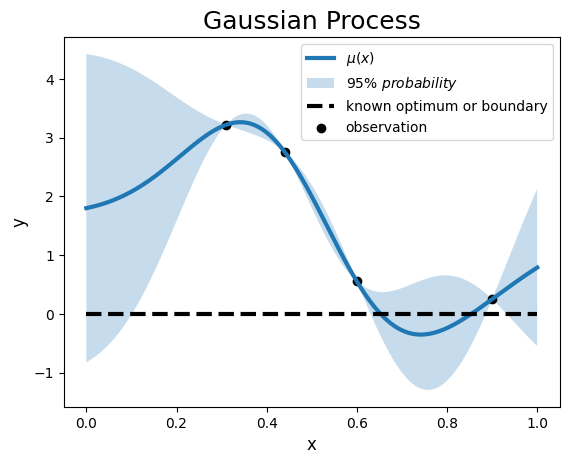

In [165]:
plt.plot(X_total,mean_predict,label='$\mu(x)$',linewidth=3)
plt.fill_between(X_total.reshape(-1,), (mean_predict-1.96*np.sqrt(var_predict)).reshape(-1,), (mean_predict+ 1.96*np.sqrt(var_predict)).reshape(-1,),alpha=0.25,label='$95 \% \ probability$')
plt.hlines(0, xmin=0,xmax=1, colors='black', linestyles='--',label='known optimum or boundary',linewidth=3)
plt.scatter(x0.reshape(-1,),y0.reshape(-1,),label='observation',color='black')
plt.legend(fontsize=10)
plt.xlabel('x',fontsize=12)
plt.ylabel('y',fontsize=12)
plt.title('Gaussian Process',fontsize=18)

# Warped GP BO

In [157]:
res = optimise_warp(x0, y0)
#res[2] = 10**(-1)
print('lengthscale is: ',np.sqrt(res[0]))
print('variance is: ',res[1])
print('c is: ',res[2])

lengthscale is:  0.17984774723572
variance is:  0.5640553086711645
c is:  0.5


In [158]:
warp_y0 = np.log(y0+res[2])
mean_warp_y0 = np.mean(warp_y0)
warp_y0_standard = warp_y0-mean_warp_y0

In [159]:
kernel = GPy.kern.RBF(input_dim=1,lengthscale= np.sqrt(res[0]),variance=res[1])  #np.sqrt(res[0])
m = GPy.models.GPRegression(x0, warp_y0_standard,kernel)
m.Gaussian_noise.variance.fix(10**(-5))

X_total = np.linspace(0,1,500).reshape(-1,1)
mean_predict,var_predict = m.predict(X_total)
mean_predict = mean_predict+mean_warp_y0
mean_predict_lognormal = np.exp(mean_predict+0.5*var_predict)-res[2]

In [160]:
p_low = 0.025
p_high = 0.975

inverse_erf_low = 1/math.erf(2*p_low-1)
inverse_erf_high = 1/math.erf(2*p_high-1)

quantile_low = np.exp(mean_predict+np.sqrt(2*var_predict)*inverse_erf_low)-res[2]
quantile_high = np.exp(mean_predict+np.sqrt(2*var_predict)*inverse_erf_high)-res[2]

Text(0.5, 1.0, 'Logarithm Gaussian Process')

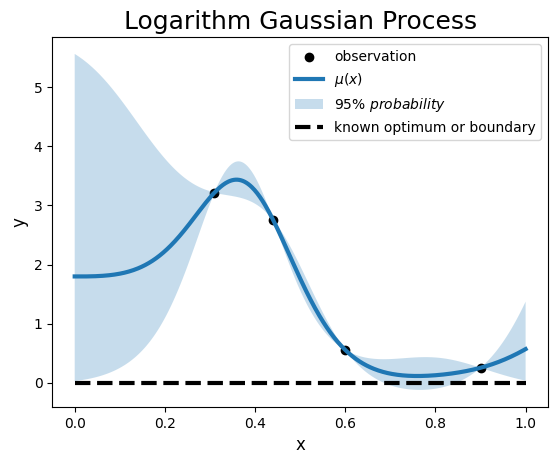

In [161]:
plt.scatter(x0,y0,label='observation',color='black')
plt.plot(X_total,mean_predict_lognormal,label='$\mu(x)$',linewidth=3)
plt.fill_between(X_total.reshape(-1,), quantile_low.reshape(-1,), quantile_high.reshape(-1,),alpha=0.25,label='$95 \% \ probability$')
plt.hlines(0, xmin=0,xmax=1, colors='black', linestyles='--',label='known optimum or boundary',linewidth=3)
plt.legend(fontsize=10)
plt.xlabel('x',fontsize=12)
plt.ylabel('y',fontsize=12)
plt.title('Logarithm Gaussian Process',fontsize=18)